<a id="segundo"></a>
## 2. Encoder-Decoder sobre imágenes
---
En la presente seccion se experimentará con arquitecturas del tipo *encoder-decoder* [[3]](#refs) aplicadas sobre imágenes, tales como *image translation*, *object location*, *image segmentation*, entre otros. La idea es aplicar una red convolucional en ambas partes del modelo (encoder y decoder), así utilizamos un modelo que se adapte a estos casos.

La tarea consistirá en realizar **Image Segmentation** [[4]](#refs) para identificar ciertos segmentos o regiones de interés en una imagen a través de procesar de manera semántica (en la codificación) si cada pixel corresponde a un segmento a destacar. Esta tarea puede ser aplicada tanto para identificar un segmento como para identificar múltiples segmentos a través de colocar varios canales/filtros de salida en el *decoder*. Para ésto trabajaremos con un dataset creado en el área (*A BENCHMARK FOR SEMANTIC IMAGE SEGMENTATION*). El dataset resulta bastante pequeño en cantidad de datos, por lo que deberá pensar en formas de conllevar ésto.

<img src="https://qph.fs.quoracdn.net/main-qimg-78a617ec1de942814c3d23dab7de0b24" width="70%" />

Descargue los datos a través del siguiente __[link](http://www.ntu.edu.sg/home/ASJFCai/Benchmark_Website/benchmark_index.html)__. Luego cargue las pocas imágenes a trabajar con la librería __[Pillow](pillow.readthedocs.io)__. Debido a la dimensionalidad variable de los datos de entrada deberá redimensionar a un valor que considere prudente, *se aconseja menos de 250*, comente su decisión.
```python
import numpy as np
import os
img_size = choose
folder = "imagefolder.."
data = [archivo.split(".")[0] for archivo in os.listdir(folder+"/image")]
from PIL import Image
X_image = []
for archivo in data:
    I = Image.open(folder+"/image/"+archivo+".jpg")
    I = np.asarray(I.resize( (img_size,img_size),Image.ANTIALIAS ))
    X_image.append(I)
X_image = np.asarray(X_image)
Y_image = []
for archivo in data:
    I = Image.open(folder+"/ground-truth/"+archivo+".png")
    I = np.asarray(I.resize( (img_size,img_size),Image.ANTIALIAS ))
    Y_image.append(I)
Y_image = np.asarray(Y_image)
```

> a) Explore los datos a trabajar, visualice la entrada y salida del modelo, además de las dimensionalidades de éstas ¿Es un problema las dimensiones de los datos *versus* la cantidad de datos a entrenar? Normalice los datos como se acostumbra en imágenes y genere una dimensión/canal extra a la salida.
```python
...#visualize and do nice plots!
X_image = X_image/255.
Y_image = Y_image/255.
Y_image = Y_image[:,:,:,None]
```

> b) Separe 10 imágenes como conjunto de pruebas para verificar la calidad del modelo entrenado.

> c) Debido a la poca cantidad de datos presentes defina la arquitectura a utilizando únicamente convolucionales (*fully convolutional*) [[5]](#refs), como la presente en el código. Comente sobre los cambios en la dimensionalidad a través del *forward pass*. Decida el tamaño del *batch* en base a la cantidad de datos que se presenta para entrenar.
```python
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization
model = Sequential()
...#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=X_image.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
...#DECODER PART
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same')) #pixel-wise classification
model.summary()
model.compile(loss='binary_crossentropy',optimizer='rmsprop')
model.fit(X_train,Y_train,epochs=100,batch_size=...)
```

> d) Para medir el desempeño del modelo sobre ambos conjuntos realice un análisis cualitativo en base a visualizar la segmentación que realiza *versus* la segmentación real, además de verificar el *precision* y *recall* asumiendo valores binarios de pixel ¿Qué valor debería ser más importante los ceros o 1? Comente.
```python
Y_hat_train = np.squeeze( model.predict(X_train) )
Y_hat_test = np.squeeze( model.predict(X_test) )
...#visualice Y_hat and Y_image
from sklearn.metrics import precision_score, recall_score
Y_label = Y_train.flatten() >0.5
Y_hat_label = Y_hat_train.flatten() >0.5
print(precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print(recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))
```

> e) Compárese con alguna técnica manual de *Image Segmentation*, comúnmente se sugiere considerar un *treshold* para activar o apagar un píxel. Experimente con utilizar *treshold* igual a la media o con otra técnica más inteligente basada en los histogramas de escala de grises, como se utilizan en *skimage*.
```python
gray_X = 0.2125*X_image[:,:,:,0]+ 0.7154*X_image[:,:,:,1]+ 0.0721*X_image[:,:,:,2] #needed gray-scale
...
""" One option"""
val = gray_X.mean()  #or another statistical
""" Another option"""
from skimage import filters
val = filters.threshold_otsu(gray_X)
... 
mask = gray_X < val
X_segmented = mask*1
```

> f) Experimente con realizar *data augmentation* sobre el problema. Debido a que las operaciones clásicas de *augmentation* como rotar, invertir, girar, cambiarian la etiqueta de segmentación, genere una estrategia que mantenga la etiqueta/salida $Y$. Se presenta un código de ejemplo, *Denoising*, de aplicar una máscara binaria aleatoria sobre la imagen de entrada $X$, **de todas formas se espera que proponga alguna distinta**. Compare el desempeño alcanzado con la nueva red con la forma de evaluar definida en (d).
```python
from numpy.random import binomial #DENOISING IDEA
T = 100
for _ in range(T):
    noise_level = np.random.randint(4,10)/10.
    noise_mask = binomial(n=1,p=noise_level,size=X_image.shape)
    X_augmented = X_image*noise_mask
    model.fit(X_augmented,Y_image,epochs=1,batch_size=32,validation_data=(X_image,Y_image))
```

> g) Intente variar la arquitectura presentada en pos de obtener un mejor modelo, basado en la evaluación realizada en (d). Recuerde tomar en cuenta la poca cantidad de datos que se tiene.

In [1]:
### Imports
import numpy as np
import os
import keras
import seaborn as sn
import skimage as sk
import matplotlib.pyplot as plt
import random as rand
import tensorflow as tf
import keras.backend as K
from keras.optimizers import SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score
from keras.layers import Input
from keras.models import Model, Sequential
from keras.regularizers import l1
from keras.layers import Conv2D,MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Input, Concatenate, Add, Dropout, Activation
from IPython.display import SVG
from keras.utils import plot_model
from skimage.measure import compare_ssim as ssim

K.set_image_dim_ordering('tf')

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
img_size = 200
folder = "p2data"
data = [archivo.split(".")[0] for archivo in os.listdir(folder+"/image")]
from PIL import Image
X_image = []
for archivo in data:
    I = Image.open(folder+"/image/"+archivo+".jpg")
    I = np.asarray(I.resize( (img_size,img_size),Image.ANTIALIAS ))
    X_image.append(I)
Y_image = []
for archivo in data:
    I = Image.open(folder+"/ground-truth/"+archivo+".png")
    I = np.asarray(I.resize( (img_size,img_size),Image.ANTIALIAS ))
    Y_image.append(I)

#Data split
    
X_test = []
Y_test = []
for i in range(10):
    rIndex = rand.randrange(len(X_image))
    X_test.append(X_image.pop(rIndex))
    Y_test.append(Y_image.pop(rIndex))
Y_image = np.asarray(Y_image)
X_image = np.asarray(X_image)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

In [3]:
print(X_image[0].shape, Y_image[0].shape)

(200, 200, 3) (200, 200)


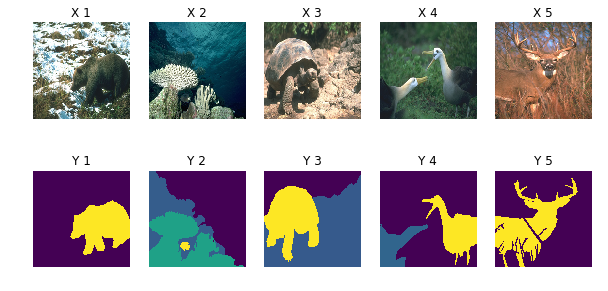

In [4]:
f,axx = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    axx[int(i/5),i%5].imshow(X_image[i] if i < 5 else Y_image[i-5])
    axx[int(i/5),i%5].axis('off')
    axx[int(i/5),i%5].set_title(f"X {i + 1}" if i < 5 else f"Y {i-4}")

In [5]:
X_image = X_image/255.
X_test = X_test/255.
Y_image = Y_image/255.
Y_image = Y_image[:,:,:,None]
Y_test = Y_test/255.
Y_test = Y_test[:,:,:,None]

In [6]:
print(X_image.shape, Y_image.shape, X_test.shape, Y_test.shape)

(90, 200, 200, 3) (90, 200, 200, 1) (10, 200, 200, 3) (10, 200, 200, 1)


### a)

Se observa que las imagenes están tomadas en una muy buena calidad con poca disrupción de los colores, por lo que son bastante buenas para el entrenamiento de un image segmentation. Sin embargo, considerando que lo que finalmente se quiere es entrenar cada pixel resultante para que pueda ser parte de la segmentación correspondiente, tener tan sólo 100 imágenes resulta una cantidad de data muy pequeña para la tarea, razón por la que las imágenes se re dimensionan a 200x200, para que el modelo pueda aprender algo con la poca cantidad de data que posee.

------------------------------

##### A partir de este punto, los siguientes items se desarrollan en conjunto con la g)

-----------------------------

### c) y d) Modelo de enunciado

In [7]:
model = Sequential()
...#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=X_image.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
...#DECODER PART
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same')) #pixel-wise classification
model.summary()
model.compile(loss='binary_crossentropy',optimizer='rmsprop')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv

In [8]:
hist = model.fit(X_image, Y_image, validation_data = (X_test, Y_test),epochs=100,batch_size=5)

Instructions for updating:
Use tf.cast instead.
Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 7s 75ms/step - loss: 0.8056 - val_loss: 0.6444
Epoch 2/100
90/90 [==============================] - 1s 12ms/step - loss: 0.6378 - val_loss: 0.6357
Epoch 3/100
90/90 [==============================] - 1s 12ms/step - loss: 0.6109 - val_loss: 0.6004
Epoch 4/100
90/90 [==============================] - 1s 11ms/step - loss: 0.6027 - val_loss: 0.6651
Epoch 5/100
90/90 [==============================] - 1s 11ms/step - loss: 0.6845 - val_loss: 0.6721
Epoch 6/100
90/90 [==============================] - 1s 11ms/step - loss: 0.6170 - val_loss: 0.6028
Epoch 7/100
90/90 [==============================] - 1s 11ms/step - loss: 0.5981 - val_loss: 0.5989
Epoch 8/100
90/90 [==============================] - 1s 11ms/step - loss: 0.5845 - val_loss: 0.6235
Epoch 9/100
90/90 [==============================] - 1s 11ms/step - loss: 0.5794 - val_loss: 0.5895
Epoch 10

90/90 [==============================] - 1s 11ms/step - loss: 0.4545 - val_loss: 0.6140
Epoch 80/100
90/90 [==============================] - 1s 11ms/step - loss: 0.4759 - val_loss: 0.5578
Epoch 81/100
90/90 [==============================] - 1s 11ms/step - loss: 0.4647 - val_loss: 0.5592
Epoch 82/100
90/90 [==============================] - 1s 11ms/step - loss: 0.4638 - val_loss: 0.5550
Epoch 83/100
90/90 [==============================] - 1s 11ms/step - loss: 0.4747 - val_loss: 0.5836
Epoch 84/100
90/90 [==============================] - 1s 12ms/step - loss: 0.4704 - val_loss: 0.5587
Epoch 85/100
90/90 [==============================] - 1s 11ms/step - loss: 0.4572 - val_loss: 0.5632
Epoch 86/100
90/90 [==============================] - 1s 11ms/step - loss: 0.4782 - val_loss: 0.5546
Epoch 87/100
90/90 [==============================] - 1s 11ms/step - loss: 0.4532 - val_loss: 0.5665
Epoch 88/100
90/90 [==============================] - 1s 12ms/step - loss: 0.4594 - val_loss: 0.5971
Epo

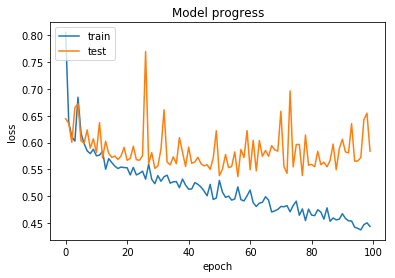

In [9]:
plt.figure(1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model progress")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [10]:
Y_test_normal = np.squeeze(Y_test)
X_test_normal = X_image*255

Y_train_normal = np.squeeze(Y_image)
X_train_normal = X_image*255

Y_test_adv = np.squeeze(Y_test)
X_test_adv = X_image*255

Y_train_adv = np.squeeze(Y_image)
X_train_adv = X_image*255

In [11]:
Y_hat1_train = np.squeeze( model.predict(X_image) )
Y_hat1_test = np.squeeze( model.predict(X_test) )
Y_label = Y_image.flatten() >0.5
Y_hat1_label = Y_hat1_train.flatten() >0.5
print(precision_score(Y_label, Y_hat1_label, average=None, labels=[0,1] ))
print(recall_score(Y_label, Y_hat1_label, average=None , labels=[0,1]))

[0.82513972 0.76616404]
[0.91566501 0.58746319]


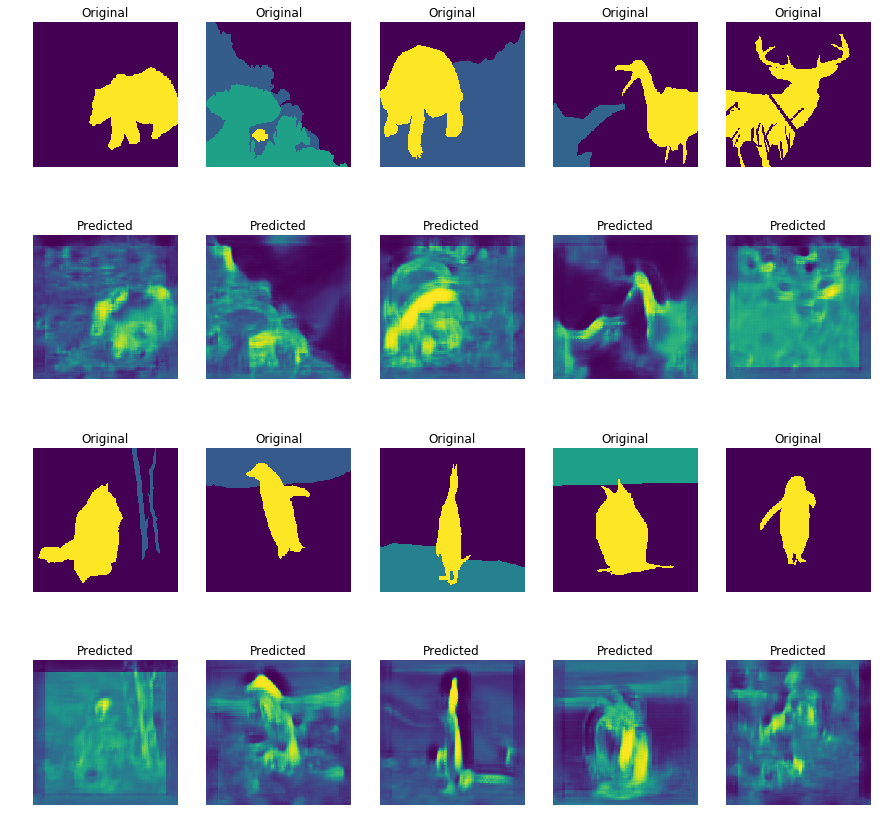

In [12]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_train_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat1_train[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

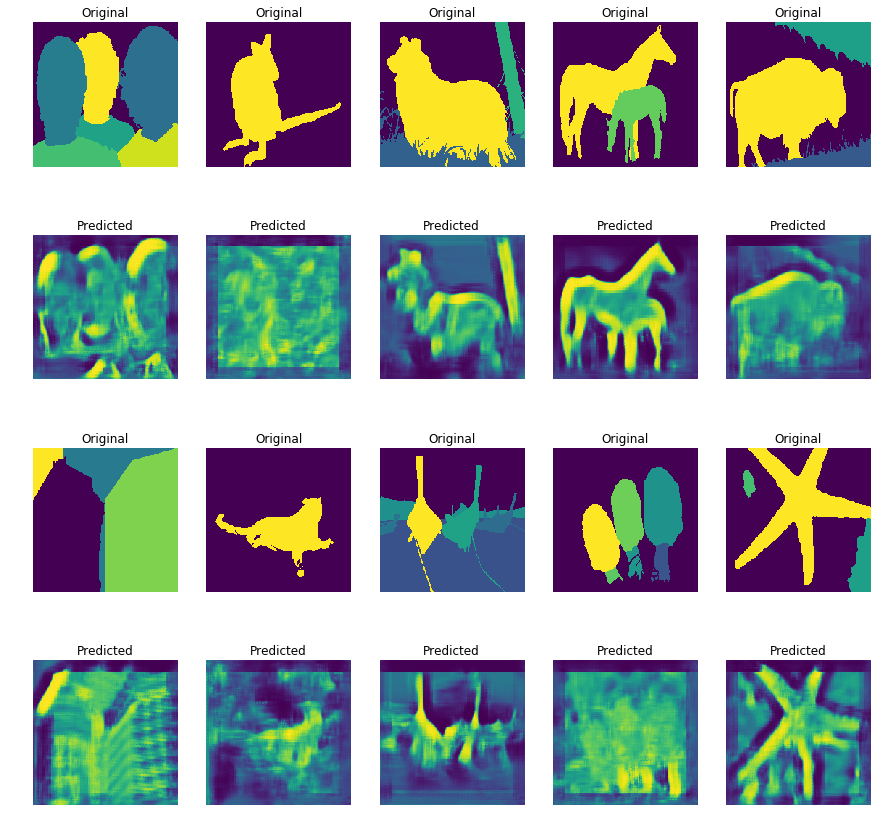

In [13]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_test_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat1_test[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

En el caso del modelo entregado por el enunciado, se observa una tendencia a overfitting además de una baja tasa de aprendizaje, esto es que aunque el modelo esté iterando demasiadas veces sobre la misma data, no está logrando realizar significantes mejoras en términos de pérdida. Esto se debe principalmente debido a la simpleza del modelo que no alcanza a extraer los features necesarios para poder generar una buena image segmentation, además la falta de data hace que tienda al overfitting, mientras que la función de pérdida binary_crossentropy sólo considera que númericamente los pixeles no estén muy lejanos a su valor "referente", pero no verifica la distribución de este error, por lo que no necesariamente mejorará como debiese, además los casos sencillos con pocas clases segmentadas le reducirán mucho el error a las que poseen mas clases y están dispersas, mientras que cualitativamente resultará en cualquier cosa, como ocurre al visualizar lo que el modelo predice.

### c) y d) Modelo propio

In [14]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [15]:
inputLayer = Input(shape=(X_image.shape[1:]))

# Encoder Layers
conv1a = Conv2D(32, (3, 3), activation='relu', padding='same')(inputLayer)
conv1b = Conv2D(32, (5, 5), activation='relu', padding='same')(inputLayer)
conv1c = Conv2D(32, (4, 4), activation='relu', padding='same')(inputLayer)
conc1 = Add()([conv1a, conv1b, conv1c])
conc2 = Concatenate(axis=-1)([conc1, inputLayer])
bn1 = BatchNormalization()(conc2)
mp1 = MaxPool2D((2,2))(bn1)
conv2a = Conv2D(64, (3, 3), activation='relu', padding='same')(mp1)
conv2b = Conv2D(64, (5, 5), activation='relu', padding='same')(mp1)
conv2c = Conv2D(64, (4, 4), activation='relu', padding='same')(mp1)
conc3 = Add()([conv2a, conv2b, conv2c])
conc4 = Concatenate(axis=-1)([conc3, mp1])
bn2 = BatchNormalization()(conc4)
mp2 = MaxPool2D((2,2))(bn2)
dp1 = Dropout(rate=0.2)(mp2)
conv3a = Conv2D(128, (3, 3), activation='relu', padding='same')(dp1)
conv3b = Conv2D(128, (5, 5), activation='relu', padding='same')(dp1)
conv3c = Conv2D(128, (4, 4), activation='relu', padding='same')(dp1)
conc5 = Add()([conv3a, conv3b, conv3c])
conc6 = Concatenate(axis=-1)([conc5, dp1])
bn3 = BatchNormalization()(conc6)

# Decoder Layers


convt1a = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(bn3)
convt1b = Conv2DTranspose(128, (5, 5), activation='relu', padding='same')(bn3)
convt1c = Conv2DTranspose(128, (4, 4), activation='relu', padding='same')(bn3)
conc7 = Add()([convt1a, convt1b, convt1c])
conc8 = Concatenate(axis=-1)([conc7, bn3])
bn4 = BatchNormalization()(conc8)
convt2a = Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(bn4)
convt2b = Conv2DTranspose(64, (5, 5), strides=(2,2), activation='relu', padding='same')(bn4)
convt2c = Conv2DTranspose(64, (4, 4), strides=(2,2), activation='relu', padding='same')(bn4)
conc9 = Add()([convt2a, convt2b, convt2c])
up1 = UpSampling2D((2,2))(bn4)
conc10 = Concatenate(axis=-1)([conc9, up1])
bn5 = BatchNormalization()(conc10)
convt3a = Conv2DTranspose(32, (3, 3), strides=(2,2), activation='relu', padding='same')(bn5)
convt3b = Conv2DTranspose(32, (5, 5), strides=(2,2), activation='relu', padding='same')(bn5)
convt3c = Conv2DTranspose(32, (4, 4), strides=(2,2), activation='relu', padding='same')(bn5)
conc11 = Add()([convt3a, convt3b, convt3c])
up2 = UpSampling2D((2,2))(bn5)
conc12 = Concatenate(axis=-1)([conc11, up2])
bn6 = BatchNormalization()(conc12)
convt4 = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(bn6)

modelAdv = Model(inputs=inputLayer, outputs=convt4)
modelAdv.summary()
modelAdv.compile(loss=[binary_focal_loss()], metrics=["accuracy"],optimizer='adadelta')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 200, 200, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 200, 200, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 200, 200, 32) 1568        input_1[0][0]               

In [16]:
hist2 = modelAdv.fit(X_image, Y_image, validation_data = (X_test, Y_test),epochs=200,batch_size=5)

Train on 90 samples, validate on 10 samples
Epoch 1/200
90/90 [==============================] - 10s 113ms/step - loss: 85145.5354 - acc: 0.4439 - val_loss: 38202.5908 - val_acc: 0.4315
Epoch 2/200
90/90 [==============================] - 7s 73ms/step - loss: 55583.7798 - acc: 0.4455 - val_loss: 39186.3633 - val_acc: 0.4443
Epoch 3/200
90/90 [==============================] - 6s 71ms/step - loss: 26695.0118 - acc: 0.4973 - val_loss: 13881.9155 - val_acc: 0.4918
Epoch 4/200
90/90 [==============================] - 6s 69ms/step - loss: 14283.8917 - acc: 0.5296 - val_loss: 12359.7734 - val_acc: 0.5274
Epoch 5/200
90/90 [==============================] - 6s 69ms/step - loss: 14432.6409 - acc: 0.5358 - val_loss: 27807.8223 - val_acc: 0.4718
Epoch 6/200
90/90 [==============================] - 6s 68ms/step - loss: 13480.2920 - acc: 0.5471 - val_loss: 29403.3457 - val_acc: 0.4250
Epoch 7/200
90/90 [==============================] - 6s 69ms/step - loss: 14845.5527 - acc: 0.5349 - val_loss: 285

90/90 [==============================] - 6s 71ms/step - loss: 5675.8042 - acc: 0.6061 - val_loss: 9109.8552 - val_acc: 0.5774
Epoch 60/200
90/90 [==============================] - 6s 70ms/step - loss: 5837.3483 - acc: 0.6002 - val_loss: 7376.6401 - val_acc: 0.5600
Epoch 61/200
90/90 [==============================] - 6s 70ms/step - loss: 4904.0796 - acc: 0.6124 - val_loss: 6121.3535 - val_acc: 0.5710
Epoch 62/200
90/90 [==============================] - 6s 69ms/step - loss: 4836.8332 - acc: 0.6156 - val_loss: 77355.9502 - val_acc: 0.5029
Epoch 63/200
90/90 [==============================] - 6s 72ms/step - loss: 6902.2814 - acc: 0.6016 - val_loss: 5910.4023 - val_acc: 0.5563
Epoch 64/200
90/90 [==============================] - 6s 71ms/step - loss: 4583.7610 - acc: 0.6148 - val_loss: 7205.8945 - val_acc: 0.5856
Epoch 65/200
90/90 [==============================] - 6s 69ms/step - loss: 4676.6453 - acc: 0.6116 - val_loss: 6489.0635 - val_acc: 0.5547
Epoch 66/200
90/90 [===================

Epoch 118/200
90/90 [==============================] - 6s 69ms/step - loss: 2738.5861 - acc: 0.6627 - val_loss: 8727.3760 - val_acc: 0.5652
Epoch 119/200
90/90 [==============================] - 6s 68ms/step - loss: 2398.9250 - acc: 0.6698 - val_loss: 10186.4287 - val_acc: 0.5790
Epoch 120/200
90/90 [==============================] - 6s 69ms/step - loss: 2591.1333 - acc: 0.6666 - val_loss: 8205.0483 - val_acc: 0.5827
Epoch 121/200
90/90 [==============================] - 6s 71ms/step - loss: 2148.0311 - acc: 0.6751 - val_loss: 8057.7588 - val_acc: 0.6005
Epoch 122/200
90/90 [==============================] - 6s 71ms/step - loss: 2212.9166 - acc: 0.6731 - val_loss: 11970.1636 - val_acc: 0.6019
Epoch 123/200
90/90 [==============================] - 7s 72ms/step - loss: 2775.5982 - acc: 0.6656 - val_loss: 13761.7896 - val_acc: 0.5622
Epoch 124/200
90/90 [==============================] - 7s 73ms/step - loss: 2230.8684 - acc: 0.6743 - val_loss: 7450.0938 - val_acc: 0.6041
Epoch 125/200
90/

90/90 [==============================] - 6s 70ms/step - loss: 676.0211 - acc: 0.7094 - val_loss: 17506.5684 - val_acc: 0.5933
Epoch 177/200
90/90 [==============================] - 7s 72ms/step - loss: 773.1583 - acc: 0.7087 - val_loss: 15016.0522 - val_acc: 0.5822
Epoch 178/200
90/90 [==============================] - 6s 70ms/step - loss: 1677.6137 - acc: 0.6968 - val_loss: 23837.3472 - val_acc: 0.5880
Epoch 179/200
90/90 [==============================] - 6s 69ms/step - loss: 1024.9693 - acc: 0.7045 - val_loss: 22580.4111 - val_acc: 0.6025
Epoch 180/200
90/90 [==============================] - 6s 69ms/step - loss: 904.7469 - acc: 0.7061 - val_loss: 16411.7847 - val_acc: 0.5948
Epoch 181/200
90/90 [==============================] - 6s 69ms/step - loss: 575.4659 - acc: 0.7108 - val_loss: 18231.9873 - val_acc: 0.6021
Epoch 182/200
90/90 [==============================] - 6s 69ms/step - loss: 489.4898 - acc: 0.7130 - val_loss: 25215.7451 - val_acc: 0.6047
Epoch 183/200
90/90 [===========

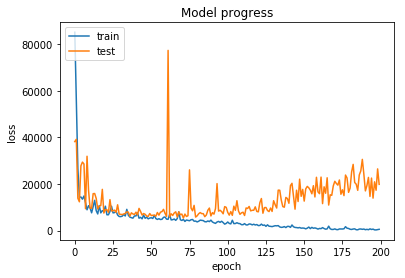

In [17]:
plt.figure(1)
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title("Model progress")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [18]:
def predictAdvWrapper(data, m=modelAdv):
    retData = []
    for image in data:
        retData.append(np.squeeze(m.predict(np.expand_dims(image, axis=0))))
    retData = np.asarray(retData)
    return retData

In [19]:
Y_hat2_train = predictAdvWrapper(X_image)
Y_hat2_test = predictAdvWrapper(X_test)
Y_label = Y_image.flatten() >0.5
Y_hat2_label = Y_hat2_train.flatten() >0.5
print(precision_score(Y_label, Y_hat2_label, average=None, labels=[0,1] ))
print(recall_score(Y_label, Y_hat2_label, average=None , labels=[0,1]))

[0.79458177 0.90409549]
[0.9768944  0.46307895]


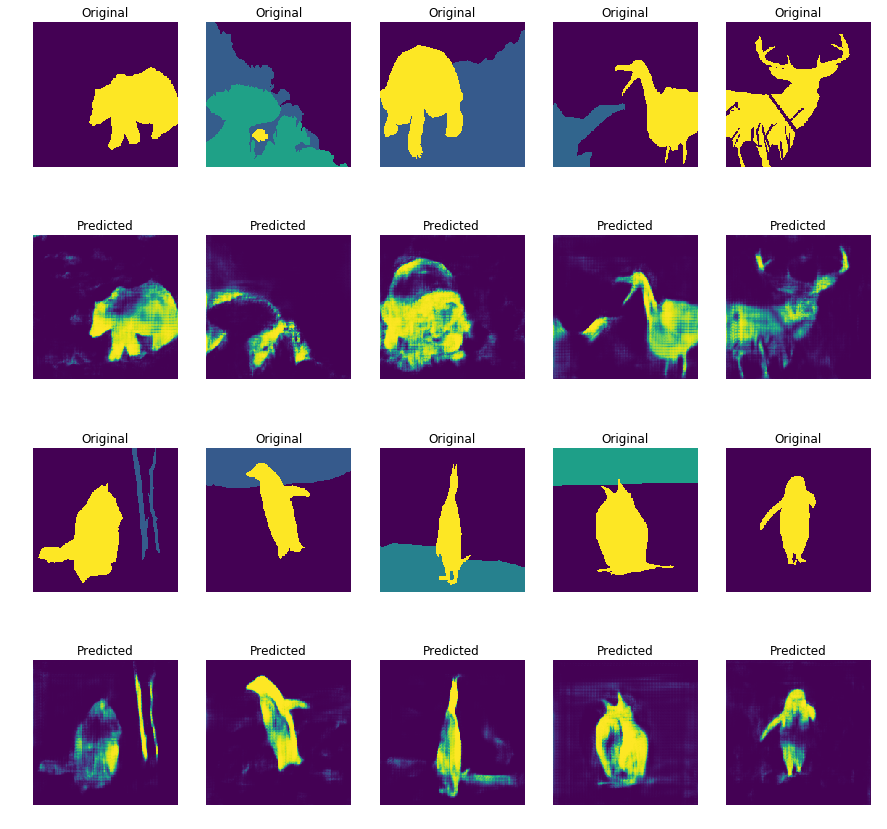

In [20]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_train_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat2_train[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

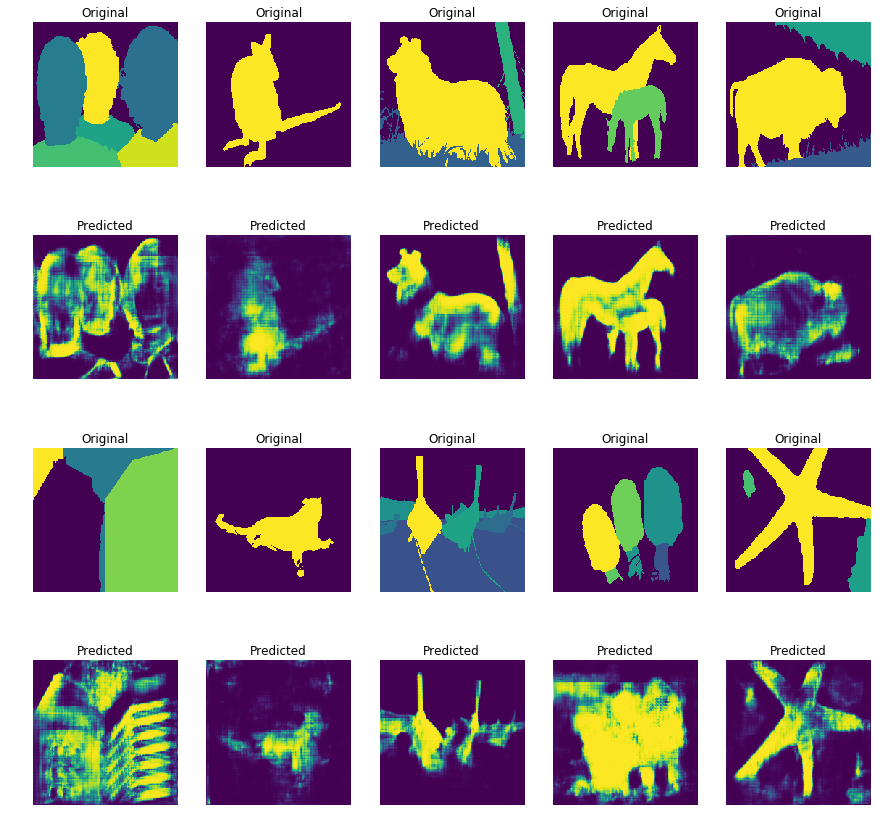

In [21]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_test_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat2_test[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

El nuevo modelo, si bien pareciera mostrar mejores resultados identificando las formas y los cuerpos que se encuentran en las imágenes, le cuesta diferenciarlos como distintos objetos en ves de como una masa conjunta que se destaca del fondo. Además de que igualmente a medida que las epoch avanzan igualmente tiende a mostrar overfitting. Esto es inevitable considerando la cantidad de data que se maneja, sin embargo la no diferenciación de colores intermedios se le puede atribuir a la función de error. Se consideró igualmente implementar otra función de error denominada distancia a la celda mas cercana, pero por razones de tiempo y complejidad de generar la matriz de distancias no se utilizó. De todas las losses que se testearon, binary crossentropy a la larga era la que mostraba mejores resultados, aunque eventualmente requiera mas datos para que cualitativamente muestre lo que uno desea. Además, se puede igualmente concluir que se pueden generar arquitecturas que aprovechen harto la poca data que se puede tener, sin embargo requiere demasiado tiempo de experimentación y análisis, ya que cada desición que se tome debe ser relevante en algún sentido.

En el caso de la arquitectura que se presenta, se esoje utilizar convoluciones paralelas con distinta ventana de convolución, para que cada una de las convoluciones logre captar distintos features relevantes a las imágenes en paralelo, para luego agregarlos. Además, se agregan skip connections para lograr enfrentar la gradiente desvaneciente y así lograr aprender lo mas posible en cada epoch. Esto si bien agrega mas parámetros de entrenamiento, estos no se encuentran acoplados, y no generan un mayor impacto de overfitting que por ejemplo el modelo anterior, sino el propio del problema de a la larga tener pocos datos de entrenamiento.

In [22]:
plot_model(modelAdv, to_file="modelAdv.png")

![Representación Gráfica del Modelo Propio](modelAdv.png)

### e)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

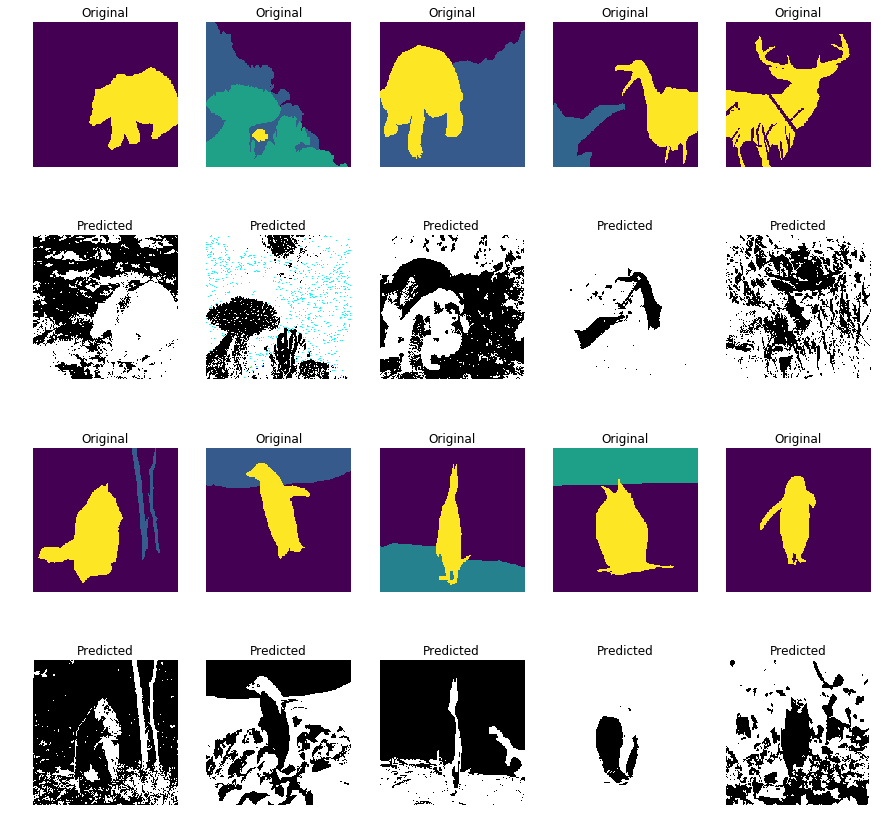

In [23]:
gray_X = 0.2125*X_image[:,:,:,0]+ 0.7154*X_image[:,:,:,1]+ 0.0721*X_image[:,:,:,2] #needed gray-scale

val = sk.filters.threshold_otsu(gray_X)

mask = gray_X < val
X_segmented = mask[:,:,:,None]*X_test_normal

f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_train_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(X_segmented[i], cmap='Greys')
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

Este método de image segmentation, se presenta cualitativamente igual que los resultados de algunas imágenes en ambos modelos, donde algunas partes del cuerpo del target a segmentar se mezcla con el fondo. Esto es entendible debido a la composición de colores que conforman los cuerpos en las imágenes, donde a veces se puede confundir con el fondo en el que se encuentra. Es por este motivo que una red convolucional puede obtener tanto mejores resultados que aplicar una máscara a la imagen original.



### f)

#### Filtro Gausiano

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


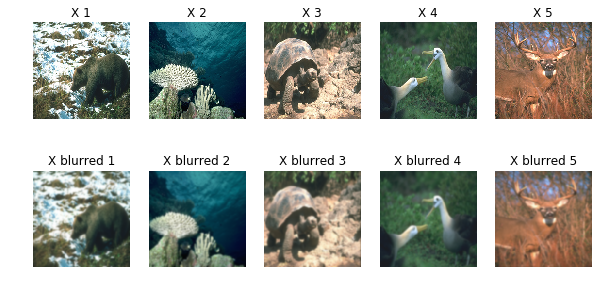

In [24]:
new_X = []
for image in X_image:
    new_X.append(sk.filters.gaussian(image, sigma=1.5))
new_X = np.asarray(new_X)
f,axx = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    axx[int(i/5),i%5].imshow(X_image[i] if i < 5 else new_X[i-5])
    axx[int(i/5),i%5].axis('off')
    axx[int(i/5),i%5].set_title(f"X {i + 1}" if i < 5 else f"X blurred {i-4}")

In [25]:
hist3_1 = model.fit(new_X,Y_image,epochs=20,batch_size=5,validation_data = (X_test, Y_test))

Train on 90 samples, validate on 10 samples
Epoch 1/20
90/90 [==============================] - 1s 12ms/step - loss: 0.4903 - val_loss: 0.6389
Epoch 2/20
90/90 [==============================] - 1s 12ms/step - loss: 0.4853 - val_loss: 0.6014
Epoch 3/20
90/90 [==============================] - 1s 12ms/step - loss: 0.4710 - val_loss: 0.5922
Epoch 4/20
90/90 [==============================] - 1s 11ms/step - loss: 0.4636 - val_loss: 0.7421
Epoch 5/20
90/90 [==============================] - 1s 12ms/step - loss: 0.4714 - val_loss: 0.6773
Epoch 6/20
90/90 [==============================] - 1s 11ms/step - loss: 0.4534 - val_loss: 0.6265
Epoch 7/20
90/90 [==============================] - 1s 12ms/step - loss: 0.4771 - val_loss: 0.6780
Epoch 8/20
90/90 [==============================] - 1s 11ms/step - loss: 0.4601 - val_loss: 0.8618
Epoch 9/20
90/90 [==============================] - 1s 12ms/step - loss: 0.4608 - val_loss: 0.6284
Epoch 10/20
90/90 [==============================] - 1s 11ms/step

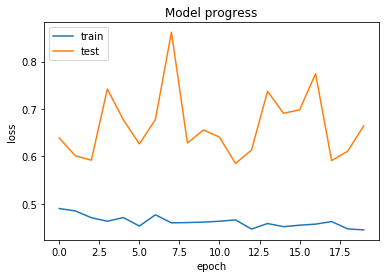

In [26]:
plt.figure(1)
plt.plot(hist3_1.history['loss'])
plt.plot(hist3_1.history['val_loss'])
plt.title("Model progress")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [27]:
Y_hat3_train = np.squeeze( model.predict(X_image) )
Y_hat3_test = np.squeeze( model.predict(X_test) )
Y_label = Y_image.flatten() >0.5
Y_hat3_label = Y_hat3_train.flatten() >0.5
print(precision_score(Y_label, Y_hat3_label, average=None, labels=[0,1] ))
print(recall_score(Y_label, Y_hat3_label, average=None , labels=[0,1]))

[0.82118522 0.65363793]
[0.84867873 0.60711268]


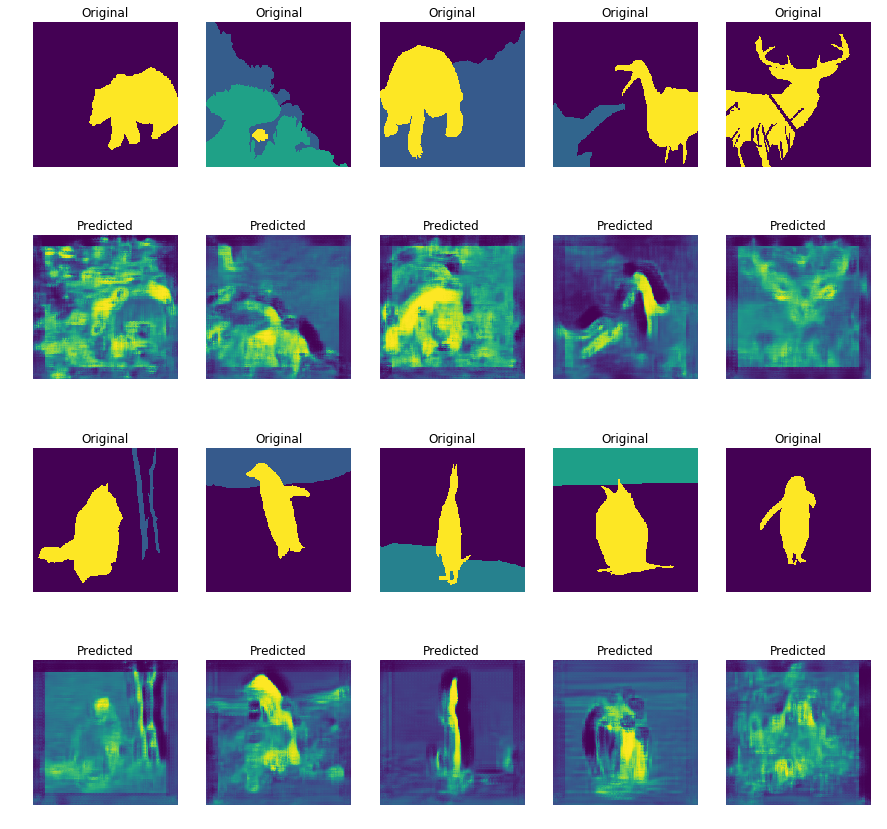

In [28]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_train_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat3_train[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

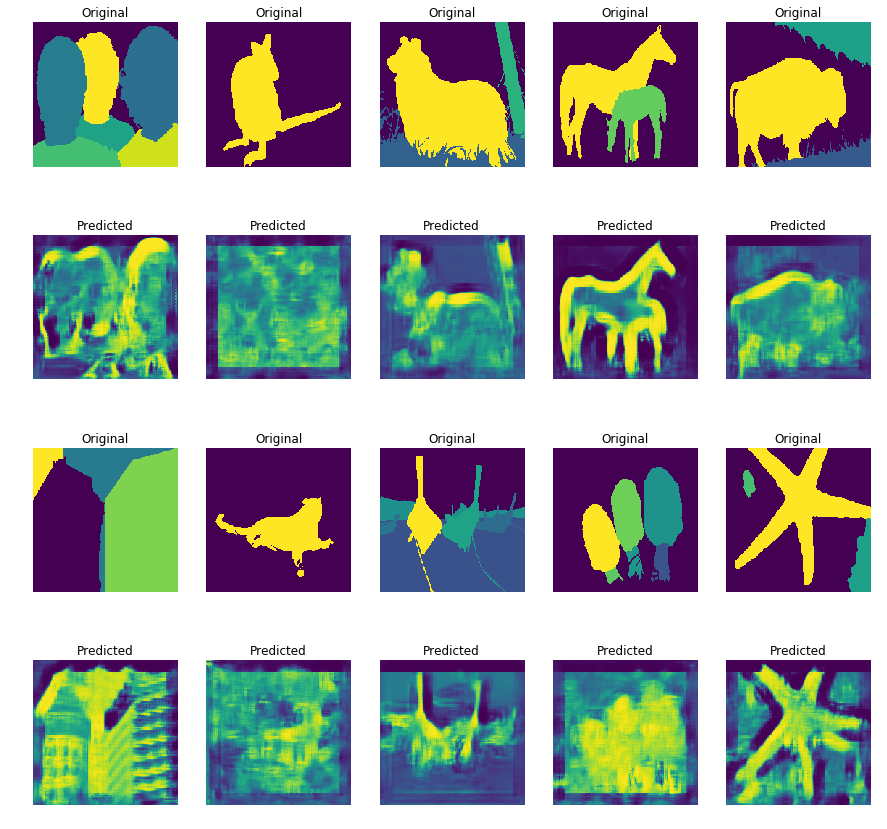

In [29]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_test_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat3_test[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

In [30]:
hist3_2 = modelAdv.fit(new_X,Y_image,epochs=20,batch_size=5,validation_data=(X_test, Y_test))

Train on 90 samples, validate on 10 samples
Epoch 1/20
90/90 [==============================] - 6s 69ms/step - loss: 8825.5089 - acc: 0.6157 - val_loss: 14426.3721 - val_acc: 0.5638
Epoch 2/20
90/90 [==============================] - 6s 69ms/step - loss: 4192.4185 - acc: 0.6389 - val_loss: 12242.2153 - val_acc: 0.5799
Epoch 3/20
90/90 [==============================] - 6s 68ms/step - loss: 3086.6219 - acc: 0.6535 - val_loss: 11963.0073 - val_acc: 0.5767
Epoch 4/20
90/90 [==============================] - 6s 70ms/step - loss: 2680.3984 - acc: 0.6655 - val_loss: 19656.6162 - val_acc: 0.5476
Epoch 5/20
90/90 [==============================] - 7s 72ms/step - loss: 2064.9008 - acc: 0.6755 - val_loss: 24790.3140 - val_acc: 0.5276
Epoch 6/20
90/90 [==============================] - 7s 73ms/step - loss: 1939.0771 - acc: 0.6823 - val_loss: 43435.8760 - val_acc: 0.4870
Epoch 7/20
90/90 [==============================] - 7s 74ms/step - loss: 1778.1359 - acc: 0.6837 - val_loss: 23691.9072 - val_ac

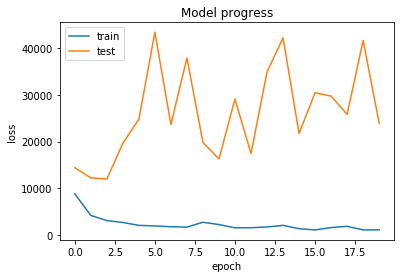

In [31]:
plt.figure(1)
plt.plot(hist3_2.history['loss'])
plt.plot(hist3_2.history['val_loss'])
plt.title("Model progress")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [32]:
Y_hat4_train = predictAdvWrapper(X_image)
Y_hat4_test = predictAdvWrapper(X_test)
Y_label = Y_image.flatten() >0.5
Y_hat4_label = Y_hat4_train.flatten() >0.5
print(precision_score(Y_label, Y_hat4_label, average=None, labels=[0,1] ))
print(recall_score(Y_label, Y_hat4_label, average=None , labels=[0,1]))

[0.80978414 0.79702817]
[0.93621953 0.5324613 ]


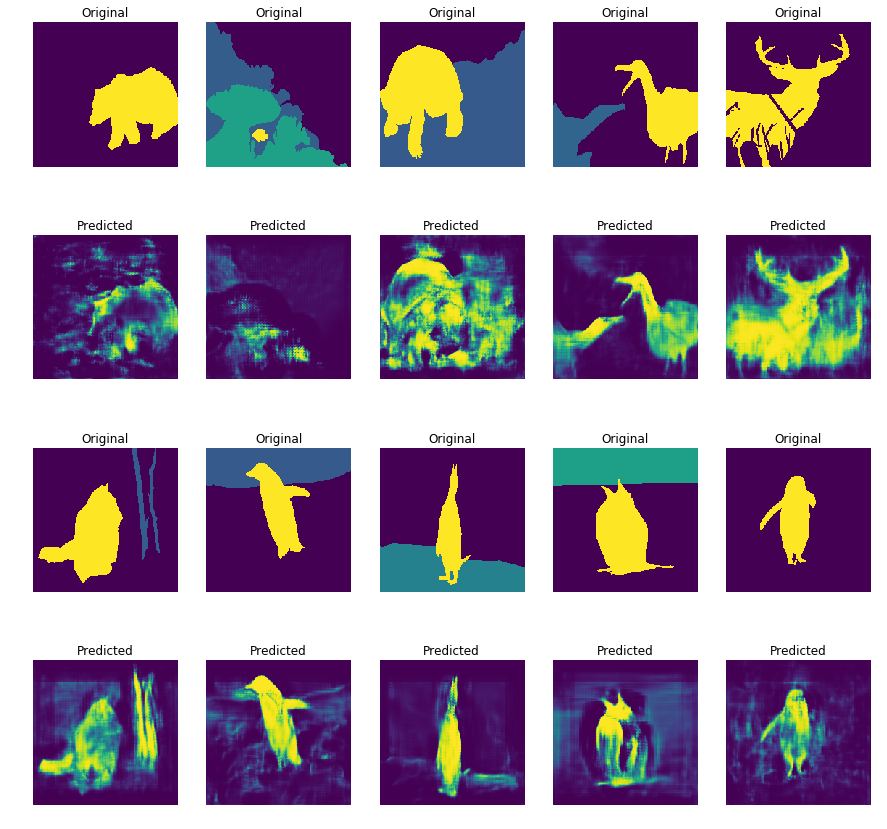

In [33]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_train_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat4_train[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

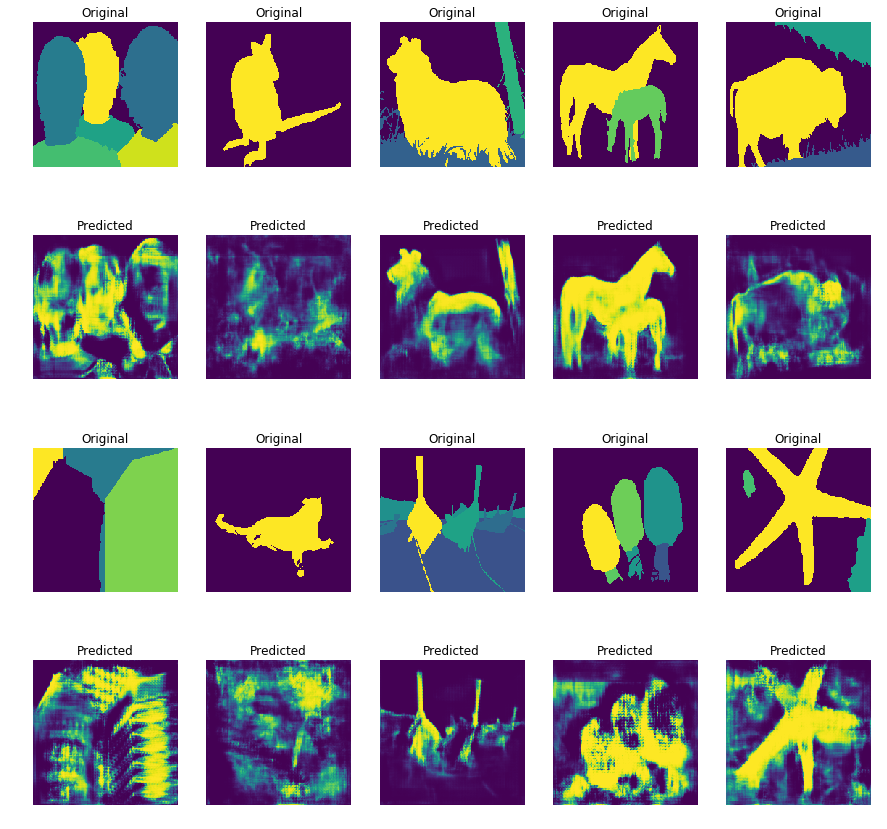

In [34]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_test_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat4_test[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

Si bien agregar filtro gausiano efectivamente genera nuevos datos de entrenamiento, lo hace disrumpiendo aleatoriamente la escencia de la imagen, lo cual en algunos casos perturba su coherencia al suavizar los bordes entre los individuos a segmentar y el fondo. Esto se puede apreciar como resultado en ambos modelos, sin embargo el segundo se muestra un tanto mas robusto a este efecto. Esto debido a su capacidad de extracción de features de las imagenes que le otorga las convoluciones paralelas.

#### Generador Automático

In [35]:
agr = ImageDataGenerator(rotation_range=180,
    width_shift_range=0.5, height_shift_range=0.5, shear_range=0.15,
    horizontal_flip=True, fill_mode="wrap")

In [36]:
hist4_1 = model.fit_generator(agr.flow(X_image, Y_image, batch_size=5), validation_data = (X_test, Y_test), steps_per_epoch = 19, epochs = 20)

Epoch 1/20
19/19 [==============================] - 1s 55ms/step - loss: 0.6160 - val_loss: 0.6092
Epoch 2/20
19/19 [==============================] - 1s 51ms/step - loss: 0.5935 - val_loss: 0.5905
Epoch 3/20
19/19 [==============================] - 1s 53ms/step - loss: 0.5853 - val_loss: 0.5836
Epoch 4/20
19/19 [==============================] - 1s 50ms/step - loss: 0.5960 - val_loss: 0.5894
Epoch 5/20
19/19 [==============================] - 1s 51ms/step - loss: 0.5783 - val_loss: 0.6123
Epoch 6/20
19/19 [==============================] - 1s 53ms/step - loss: 0.6018 - val_loss: 0.6024
Epoch 7/20
19/19 [==============================] - 1s 52ms/step - loss: 0.5997 - val_loss: 0.5890
Epoch 8/20
19/19 [==============================] - 1s 55ms/step - loss: 0.5801 - val_loss: 0.6439
Epoch 9/20
19/19 [==============================] - 1s 51ms/step - loss: 0.5829 - val_loss: 0.5932
Epoch 10/20
19/19 [==============================] - 1s 51ms/step - loss: 0.5887 - val_loss: 0.6007
Epoch 11/

In [37]:
hist4_2 = modelAdv.fit_generator(agr.flow(X_image, Y_image, batch_size=5), validation_data = (X_test, Y_test), steps_per_epoch = 19, epochs = 20)

Epoch 1/20
19/19 [==============================] - 6s 342ms/step - loss: 11606.4818 - acc: 0.5609 - val_loss: 15131.5049 - val_acc: 0.4903
Epoch 2/20
19/19 [==============================] - 7s 348ms/step - loss: 7514.1140 - acc: 0.5782 - val_loss: 12865.5547 - val_acc: 0.5169
Epoch 3/20
19/19 [==============================] - 6s 341ms/step - loss: 7608.1030 - acc: 0.5659 - val_loss: 8771.7295 - val_acc: 0.5339
Epoch 4/20
19/19 [==============================] - 7s 366ms/step - loss: 6649.9532 - acc: 0.5808 - val_loss: 8495.5593 - val_acc: 0.5312
Epoch 5/20
19/19 [==============================] - 7s 345ms/step - loss: 6691.6652 - acc: 0.5406 - val_loss: 7265.3347 - val_acc: 0.5364
Epoch 6/20
19/19 [==============================] - 7s 365ms/step - loss: 6718.4219 - acc: 0.5830 - val_loss: 6818.8140 - val_acc: 0.5363
Epoch 7/20
19/19 [==============================] - 7s 346ms/step - loss: 6480.8843 - acc: 0.5727 - val_loss: 7133.6907 - val_acc: 0.5357
Epoch 8/20
19/19 [=============

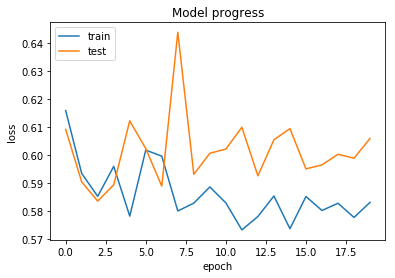

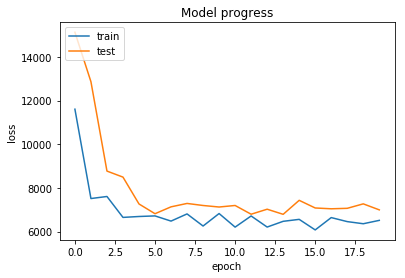

In [38]:
plt.figure(1)
plt.plot(hist4_1.history['loss'])
plt.plot(hist4_1.history['val_loss'])
plt.title("Model progress")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(2)
plt.plot(hist4_2.history['loss'])
plt.plot(hist4_2.history['val_loss'])
plt.title("Model progress")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [39]:
Y_hat5_train = np.squeeze( model.predict(X_image) )
Y_hat5_test = np.squeeze( model.predict(X_test) )
Y_label = Y_image.flatten() >0.5
Y_hat5_label = Y_hat5_train.flatten() >0.5
print(precision_score(Y_label, Y_hat5_label, average=None, labels=[0,1] ))
print(recall_score(Y_label, Y_hat5_label, average=None , labels=[0,1]))

[0.68133429 0.98882175]
[0.99996978 0.0056841 ]


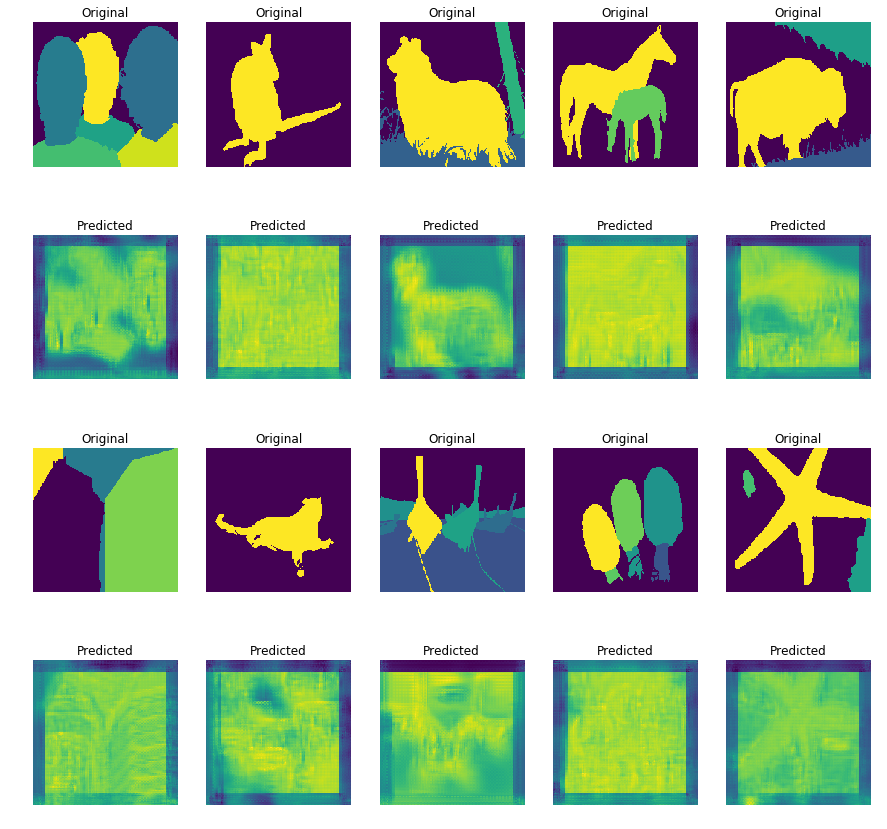

In [40]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_test_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat5_test[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

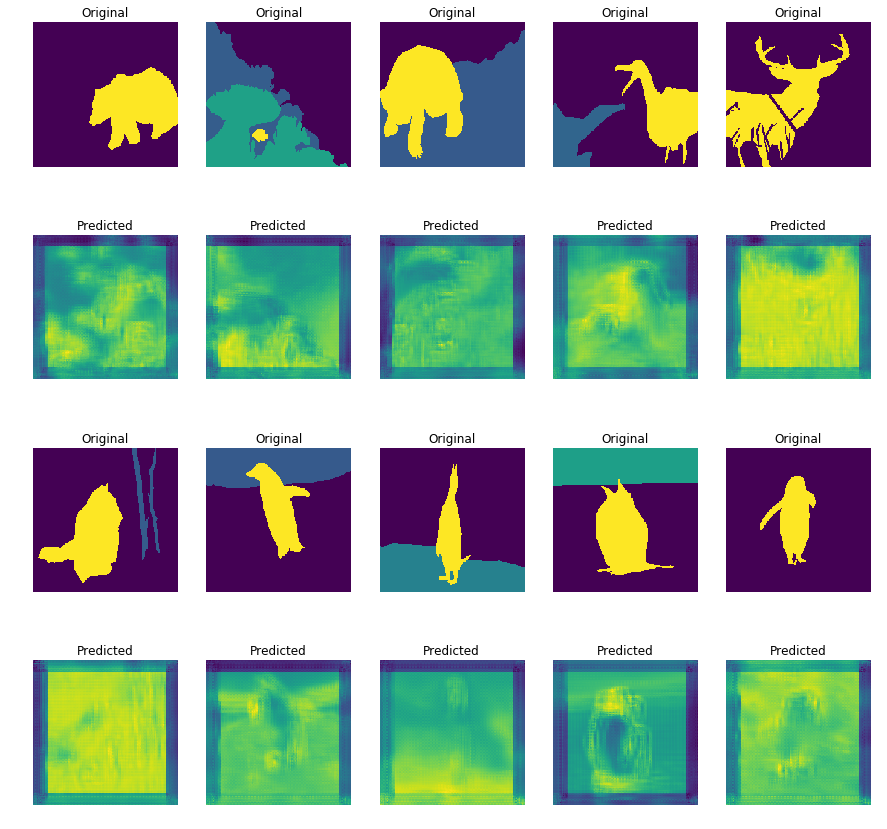

In [41]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_train_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat5_train[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

In [42]:
Y_hat6_train = predictAdvWrapper(X_image)
Y_hat6_test = predictAdvWrapper(X_test)
Y_label = Y_image.flatten() >0.5
Y_hat6_label = Y_hat6_train.flatten() >0.5
print(precision_score(Y_label, Y_hat6_label, average=None, labels=[0,1] ))
print(recall_score(Y_label, Y_hat6_label, average=None , labels=[0,1]))

[0.6800829  0.29639794]
[9.99162299e-01 7.50239008e-04]


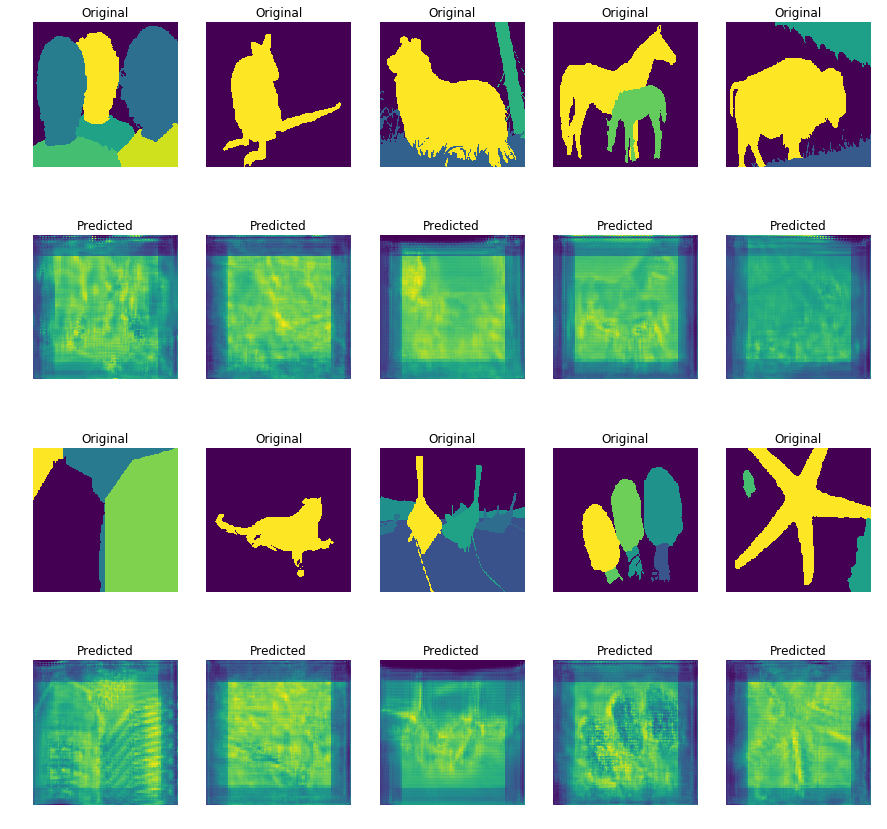

In [43]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_test_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat6_test[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

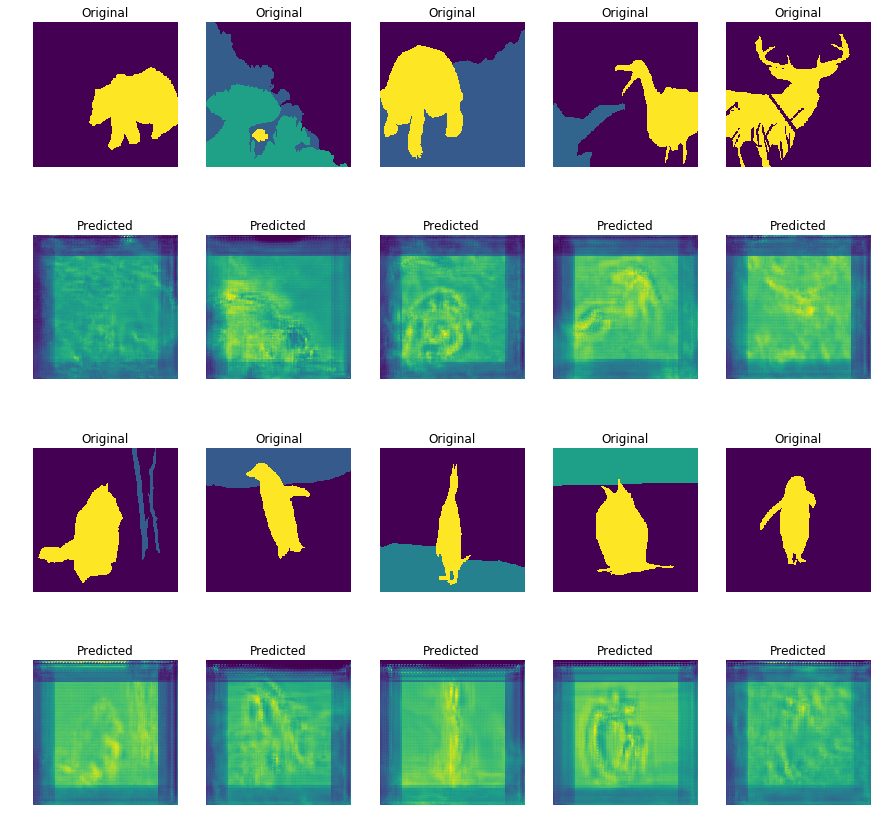

In [44]:
f,axx = plt.subplots(4,5,figsize=(15,15))
for i in range(10):
    axx[int(i/5)*2,i%5].imshow(Y_train_normal[i])
    axx[int(i/5)*2,i%5].axis('off')
    axx[int(i/5)*2,i%5].set_title("Original")
    
    axx[int(i/5)*2 + 1,i%5].imshow(Y_hat6_train[i])
    axx[int(i/5)*2 + 1,i%5].axis('off')
    axx[int(i/5)*2 + 1,i%5].set_title("Predicted")

En este punto, se observa que las imagenes resultantes se disrumpen bastante siendo que las transformaciones que se le aplican no debiesen cambiar su escencia de por sí. Tras investigar al respecto se observa que las transformaciones solamente se le aplican a los datos de entrenamiento y no a las etiquetas, lo que finalemente termina por ensuciar todo lo aprendido por el modelo. Se evalúa haber generado estas mismas transformaciones aleatorias que mantienen las escencias y coherencias de las imágenes tanto a los datos de entrenamiento como de etiquetado, sin embargo por razones de tiempo no se logra implementar.